In [230]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import h5py
import sklearn
from sklearn.model_selection import train_test_split
from collections import Counter
import glob
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import train
from random import shuffle
import imp
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
%matplotlib inline

In [260]:
characters = [k.split('/')[2] for k in glob.glob('./characters/*') if len([p for p in glob.glob(k+'/*') 
                                                                           if 'edited' in p or 'pic_vid' in p]) > 290]
map_characters = dict(enumerate(characters))
print(map_characters)

{0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson', 3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'homer_simpson', 6: 'krusty_the_clown', 7: 'lisa_simpson', 8: 'marge_simpson', 9: 'milhouse_van_houten', 10: 'moe_szyslak', 11: 'ned_flanders', 12: 'principal_skinner', 13: 'sideshow_bob'}


In [492]:
X_train, X_test, y_train, y_test = train.get_dataset()

Train (10145, 64, 64, 3) (10145, 14)
Test (1791, 64, 64, 3) (1791, 14)
moe_szyslak : 1019 train pictures & 157 test pictures
marge_simpson : 1012 train pictures & 164 test pictures
lisa_simpson : 983 train pictures & 193 test pictures
bart_simpson : 982 train pictures & 194 test pictures
homer_simpson : 981 train pictures & 195 test pictures
ned_flanders : 942 train pictures & 159 test pictures
krusty_the_clown : 836 train pictures & 147 test pictures
charles_montgomery_burns : 787 train pictures & 135 test pictures
abraham_grampa_simpson : 689 train pictures & 121 test pictures
sideshow_bob : 560 train pictures & 95 test pictures
principal_skinner : 387 train pictures & 69 test pictures
chief_wiggum : 371 train pictures & 59 test pictures
apu_nahasapeemapetilon : 306 train pictures & 45 test pictures
milhouse_van_houten : 290 train pictures & 58 test pictures


In [267]:
imp.reload(train)
## Just creating dataset
X_train, X_test, y_train, y_test = train.get_dataset(save=True)

Train (9718, 64, 64, 3) (9718, 14)
Test (1716, 64, 64, 3) (1716, 14)
marge_simpson : 1020 train pictures & 156 test pictures
moe_szyslak : 997 train pictures & 179 test pictures
homer_simpson : 993 train pictures & 183 test pictures
lisa_simpson : 990 train pictures & 186 test pictures
bart_simpson : 968 train pictures & 208 test pictures
ned_flanders : 834 train pictures & 135 test pictures
krusty_the_clown : 794 train pictures & 132 test pictures
charles_montgomery_burns : 772 train pictures & 119 test pictures
abraham_grampa_simpson : 680 train pictures & 106 test pictures
sideshow_bob : 535 train pictures & 98 test pictures
chief_wiggum : 333 train pictures & 57 test pictures
principal_skinner : 305 train pictures & 56 test pictures
milhouse_van_houten : 250 train pictures & 51 test pictures
apu_nahasapeemapetilon : 247 train pictures & 50 test pictures


#### Four convulational layers

##### Same pictures training/testing

In [271]:
## Training in the notebook
# X_train, X_test, y_train, y_test = train.get_dataset()
# model, opt = train.create_model(X_train.shape[1:])
# model.compile(loss='categorical_crossentropy',
#               optimizer=opt,
#               metrics=['accuracy'])
# model, history = train.training(model, X_train, X_test, y_train, y_test, data_augmentation=True)

## Training on AWS
# X_train, X_test, y_train, y_test = train.get_dataset(load=True)
model = keras.models.load_model('./models/model_08-06.h5')
with open('./models/history_08_06.pkl', 'rb') as f:
    history = pickle.load(f)
y_pred = model.predict(X_test)
print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], 
                                                  np.argmax(y_pred, axis=1), 
                                                  target_names=list(map_characters.values())), sep='')


                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.97      0.92      0.94       106
  apu_nahasapeemapetilon       0.92      0.98      0.95        50
            bart_simpson       0.99      0.87      0.93       208
charles_montgomery_burns       1.00      0.86      0.92       119
            chief_wiggum       0.98      0.98      0.98        57
           homer_simpson       0.90      0.97      0.94       183
        krusty_the_clown       1.00      0.98      0.99       132
            lisa_simpson       0.82      0.98      0.89       186
           marge_simpson       0.99      0.99      0.99       156
     milhouse_van_houten       0.96      0.96      0.96        51
             moe_szyslak       0.97      0.96      0.96       179
            ned_flanders       0.94      0.98      0.96       135
       principal_skinner       0.96      0.89      0.93        56
            sideshow_bob       0.99      0.97      0.98        98

       

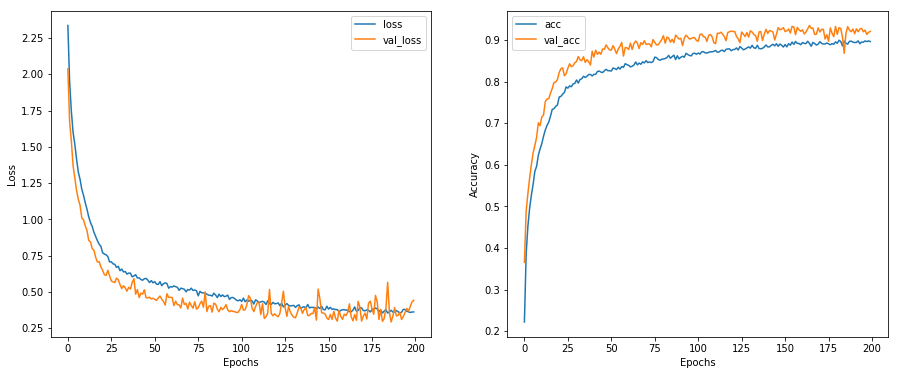

In [272]:
epochs= range(200)
f, ax = plt.subplots(ncols=2, figsize=(15,6))
ax[0].plot(epochs, history['loss'], label='loss')
ax[0].plot(epochs, history['val_loss'], label='val_loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(epochs, history['acc'], label='acc')
ax[1].plot(epochs, history['val_acc'], label='val_acc')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

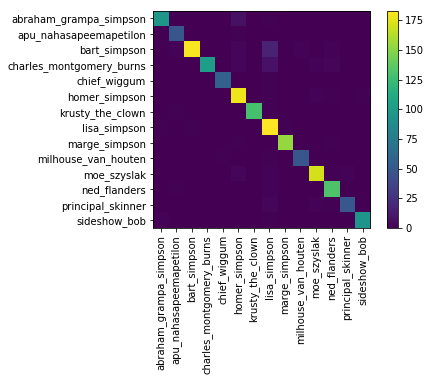

In [273]:
cnf_matrix = sklearn.metrics.confusion_matrix(np.where(y_test > 0)[1], np.argmax(y_pred, axis=1))
classes = list(map_characters.values())
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

##### With BGR/RGB

In [249]:
X_test2 = []
for img in X_test:
    X_test2.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
X_test2 = np.array(X_test2)
model = keras.models.load_model('./models/model_BGR.h5')
y_pred = model.predict(X_test2)
print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], 
                                                  np.argmax(y_pred, axis=1), 
                                                  target_names=list(map_characters.values())), sep='')


                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.86      0.95      0.91        86
            bart_simpson       0.95      0.82      0.88       179
charles_montgomery_burns       0.93      0.86      0.89       135
           homer_simpson       0.88      0.90      0.89       171
        krusty_the_clown       0.94      0.97      0.95        92
            lisa_simpson       0.85      0.94      0.89       188
           marge_simpson       0.99      0.97      0.98       167
             moe_szyslak       0.94      0.95      0.94       171
            ned_flanders       1.00      0.92      0.96       102
            sideshow_bob       0.86      0.97      0.91        67

             avg / total       0.92      0.92      0.92      1358



#### Six convolutional layers 

In [19]:
## Training on AWS
X_train, X_test, y_train, y_test = train.get_dataset(load=True)
model = keras.models.load_model('./models/model_sixconv.h5')
with open('./models/history2.pkl', 'rb') as f:
    history = pickle.load(f)
y_pred = model.predict(X_test)
print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], 
                                                  np.argmax(y_pred, axis=1), 
                                                  target_names=list(map_characters.values())), sep='')

Train (6893, 64, 64, 3) (6893, 10)
Test (766, 64, 64, 3) (766, 10)

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.93      0.95      0.94        58
            bart_simpson       0.83      0.89      0.86        89
charles_montgomery_burns       0.87      0.68      0.76        76
           homer_simpson       0.90      0.94      0.92       147
        krusty_the_clown       0.91      0.98      0.94        41
            lisa_simpson       0.90      0.85      0.87       102
           marge_simpson       0.96      0.95      0.96       108
             moe_szyslak       0.80      0.89      0.84        45
            ned_flanders       0.93      0.86      0.89        59
            sideshow_bob       0.84      0.93      0.88        41

             avg / total       0.89      0.89      0.89       766



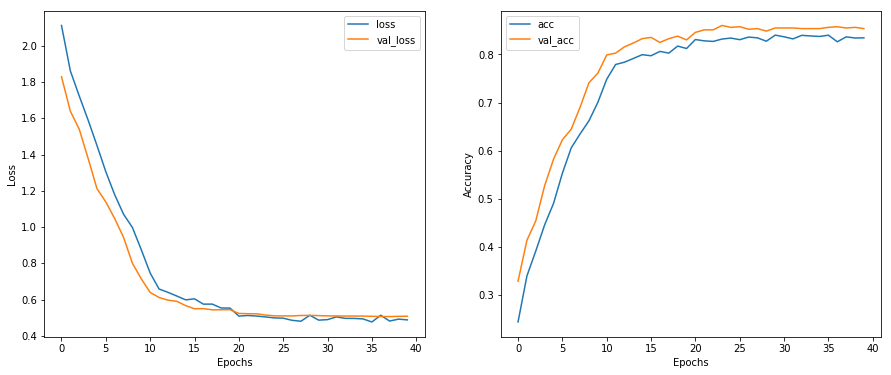

In [21]:
epochs= range(40)
f, ax = plt.subplots(ncols=2, figsize=(15,6))
ax[0].plot(epochs, history['loss'], label='loss')
ax[0].plot(epochs, history['val_loss'], label='val_loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(epochs, history['acc'], label='acc')
ax[1].plot(epochs, history['val_acc'], label='val_acc')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

In [22]:
## -> More overfitting

#### Predict from url

In [340]:
import urllib
def url_to_image(url):
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    return image

def plot_and_predict(url, all_perc=False):
    image = url_to_image(url)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    pic = cv2.resize(image, (pic_size,pic_size))
    a = model.predict_proba(pic.reshape(1, pic_size, pic_size,3))[0]
    if all_perc:
        print('\n'.join(['{} : {}%'.format(map_characters[i], round(k*100)) for i,k in sorted(enumerate(a), key=lambda x:x[1], reverse=True)]))
    else:
        return map_characters[np.argmax(a)].replace('_',' ').title()

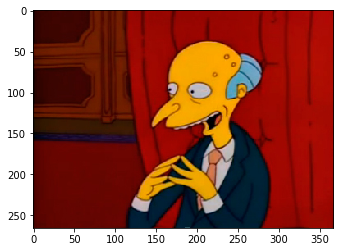

1/1 [==============================] - 0s


'Charles Montgomery Burns'

In [345]:
url = "https://vignette3.wikia.nocookie.net/simpsons/images/2/25/Adult_burns.jpg/revision/latest?cb=20111012170021"
plot_and_predict(url)

#### Generating and plotting

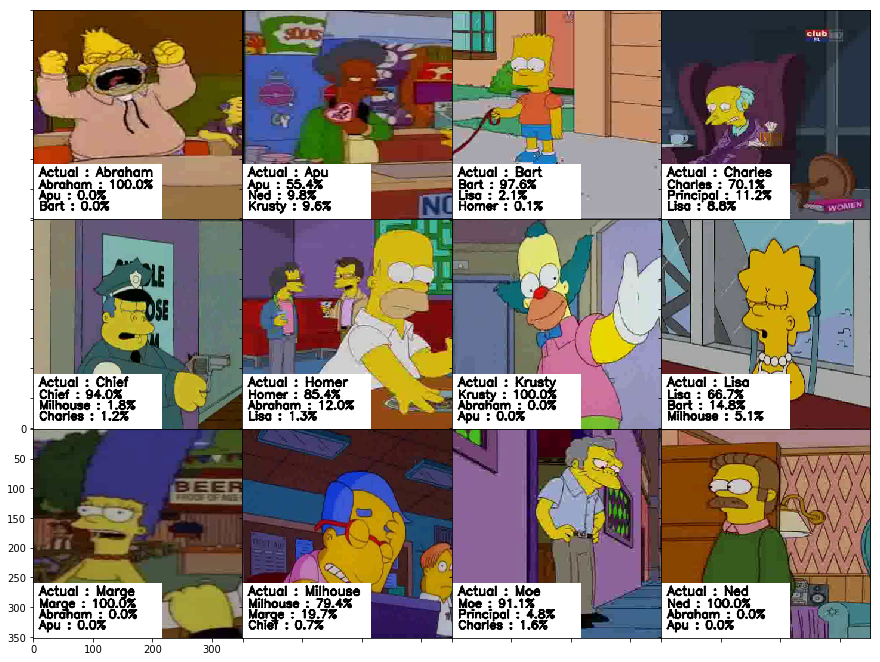

In [451]:
from mpl_toolkits.axes_grid1 import AxesGrid
map_characters = {0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson', 
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'homer_simpson', 
    6: 'krusty_the_clown', 7: 'lisa_simpson', 8: 'marge_simpson', 
    9: 'milhouse_van_houten', 10: 'moe_szyslak', 11: 'ned_flanders', 
    12: 'principal_skinner', 13: 'sideshow_bob'}

F = plt.figure(1, (15,20))
grid = AxesGrid(F, 111,  # similar to subplot(141)
                nrows_ncols=(3, 4),
                axes_pad=0,
                label_mode="1")

for i in range(12):
    char = map_characters[i]
    image = cv2.imread(np.random.choice([k for k in glob.glob('./characters/%s/*' % char) if 'pic_vid' in k]))
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pic = cv2.resize(image, (64, 64)).astype('float32') / 255.
    a = model.predict(pic.reshape(1, 64, 64,3))[0]
    actual = char.split('_')[0].title()
#     pred = map_characters[np.argmax(a)].split('_')[0].title()
    text = sorted(['{:s} : {:.1f}%'.format(map_characters[k].split('_')[0].title(), 100*v) for k,v in enumerate(a)], 
       key=lambda x:float(x.split(':')[1].split('%')[0]), reverse=True)[:3]
    img = cv2.resize(img, (352, 352))
    cv2.rectangle(img, (0,260),(215,352),(255,255,255), -1)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, 'Actual : %s' % actual, (10, 280), font, 0.7,(0,0,0),2,cv2.LINE_AA)
    for k, t in enumerate(text):
        cv2.putText(img, t,(10, 300+k*18), font, 0.65,(0,0,0),2,cv2.LINE_AA)
#     cv2.putText(img, 'Pred : %s' % pred, (100, 310), font, 0.7,(0,0,0),2,cv2.LINE_AA)    
    grid[i].imshow(img)

#### Computing threshold

In [526]:
value_best_true = []
diff_bests_true = []
std_vals = []
y_pred = model.predict(X_test, verbose=0)
for k in range(len(y_test)):
    elem = sorted(y_pred[0])[::-1]
    value_best_true.append(elem[0])
    diff_bests_true.append((elem[0] - elem[1]))
    std_vals.append(np.std(elem))

comp = np.argmax(y_test, axis=1) == np.argmax(y_pred, axis=1)
index_good, index_false = [i for i, x in enumerate(comp) if x], [i for i, x in enumerate(comp) if not x]

In [528]:
good_best = np.array(value_best_true)[index_good]
good_diff = np.array(diff_bests_true)[index_good]
wrong_best = np.array(value_best_true)[index_false]
wrong_diff = np.array(diff_bests_true)[index_false]
good_std = np.array(std_vals)[index_good]
false_std = np.array(std_vals)[index_false]
print("For good predictions : \nMax : {}, Difference Two First : {}, STD : {}".format(np.mean(good_best),
                                                                            np.mean(good_diff),
                                                                            np.mean(good_std)))
print("For wrong predictions : \nMax : {}, Difference Two First : {}, STD : {}".format(np.mean(wrong_best),
                                                                             np.mean(wrong_diff),
                                                                            np.mean(false_std)))

For good predictions : 
Max : 0.7171574234962463, Difference Two First : 0.6794835925102234, STD : 0.17942871153354645
For wrong predictions : 
Max : 0.7171573638916016, Difference Two First : 0.6794836521148682, STD : 0.17942871153354645


In [537]:
np.mean(np.max(y_pred[index_false], axis=1)), np.mean(np.max(y_pred[index_good], axis=1))

(0.37645096, 0.83031267)

In [547]:
np.mean(np.diff(np.sort(y_pred[index_false], axis=1)[:, 12:])), np.mean(np.diff(np.sort(y_pred[index_good], axis=1)[:, 12:]))

(0.18645835, 0.76626551)

#### Attention maps

Working on filters: [5]
homer_simpson
Working on filters: [5]
homer_simpson
Working on filters: [10]
moe_szyslak
Working on filters: [8]
marge_simpson
Working on filters: [2]
bart_simpson


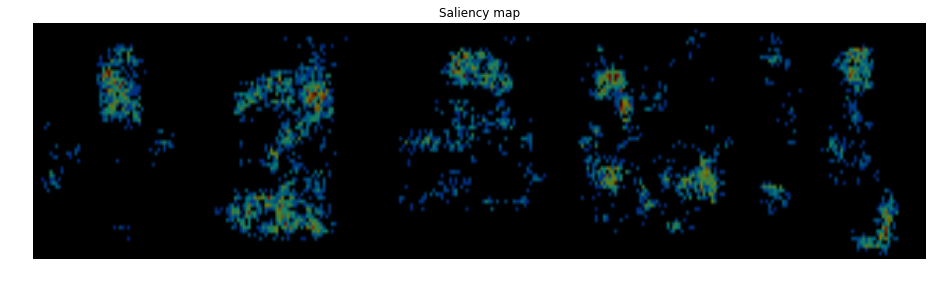

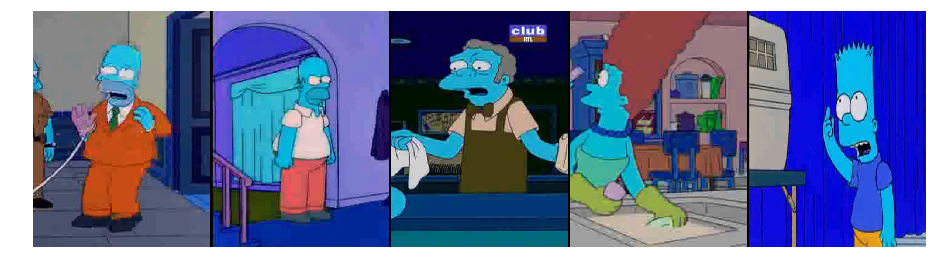

In [277]:
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import preprocess_input

from vis.utils import utils
from vis.utils.vggnet import VGG16
from vis.visualization import visualize_saliency

# The name of the layer we want to visualize
# (see model definition in vggnet.py)
layer_idx = [idx for idx, layer in enumerate(model.layers)][16]

# Images corresponding to tiger, penguin, dumbbell, speedboat, spider
image_paths = [
    './characters/homer_simpson/pic_video10_54.jpg',
    './characters/homer_simpson/pic_video6_1881.jpg',
    './characters/moe_szyslak/pic_video5_8780.jpg',
    './characters/marge_simpson/pic_video6_49.jpg',
    './characters/bart_simpson/pic_video0_460.jpg',
]

heatmaps = []
true_img = []
for path in image_paths:
    seed_img1 = cv2.imread(path)
    seed_img = cv2.resize(seed_img1, (64,64)).astype('float32') / 255.
    seed_img  = seed_img.reshape((1,64,64,3))
    pred_class = np.argmax(model.predict(seed_img))

    # Here we are asking it to show attention such that prob of `pred_class` is maximized.
    heatmap = visualize_saliency(model, layer_idx, [pred_class], seed_img.reshape((64, 64, 3)))
    heatmaps.append(cv2.resize(heatmap, (480,640))) 
    true_img.append(cv2.resize(seed_img1,(480,640)))
    print(map_characters[pred_class])

plt.figure(figsize=(16,10))
plt.axis('off')
plt.imshow(utils.stitch_images(heatmaps))
plt.title('Saliency map')
plt.show()

plt.figure(figsize=(16,10))
plt.axis('off')
plt.imshow(utils.stitch_images(true_img))
plt.show()

#### Create video

In [483]:
m, s = 5, 7
cap = cv2.VideoCapture("video1.avi") 
nb_frames = 2500

fps = cap.get(cv2.CAP_PROP_FPS)
cap.set(1, fps*(m*60+s))
for i in range(4000):
    ret, frame = cap.read()
    if i % 15 == 0:
        img = cv2.resize(frame, (64, 64)).astype('float32') / 255.
        a = model.predict(img.reshape((-1, 64, 64, 3)), verbose=0)[0]
        text = sorted(['{:s} : {:.1f}%'.format(map_characters[k].split('_')[0].title(), 100*v) for k,v in enumerate(a)], 
               key=lambda x:float(x.split(':')[1].split('%')[0]), reverse=True)[:3]
    im = frame
    cv2.rectangle(im, (int(frame.shape[1] * 0.6),int(frame.shape[0] * 0.7)),(frame.shape[1],frame.shape[0]),(255,255,255), -1)
    font = cv2.FONT_HERSHEY_SIMPLEX
    for k, t in enumerate(text):
        cv2.putText(im,t,
                    ((int(frame.shape[1] * 0.6 + 10), int(frame.shape[0] * 0.7 + 20 +k*25))), 
                    font, 0.8,(0,0,0),2,cv2.LINE_AA)
    cv2.imwrite('./video_created/vid_{0:0=4d}.jpg'.format(i), im)
 
# !ffmpeg -f image2 -r 25 -i ./video_created/vid_%04d.jpg -vcodec mpeg4 -y ./video_created/movie3.mp4

# for i in glob.glob('./video_created/*.jpg'):
#     os.remove(i)

In [488]:
!ffmpeg -f image2 -r 25 -i ./video_created/video_%05d.jpg -vcodec mpeg4 -y ./video_created/movie4.mp4

ffmpeg version 3.2.4 Copyright (c) 2000-2017 the FFmpeg developers
  built with Apple LLVM version 8.0.0 (clang-800.0.42.1)
  configuration: --prefix=/opt/local --enable-swscale --enable-avfilter --enable-avresample --enable-libmp3lame --enable-libvorbis --enable-libopus --enable-libtheora --enable-libschroedinger --enable-libopenjpeg --enable-libmodplug --enable-libvpx --enable-libsoxr --enable-libspeex --enable-libass --enable-libbluray --enable-lzma --enable-gnutls --enable-fontconfig --enable-libfreetype --enable-libfribidi --disable-libxcb --disable-libxcb-shm --disable-libxcb-xfixes --disable-indev=jack --disable-outdev=xv --enable-audiotoolbox --enable-sdl2 --mandir=/opt/local/share/man --enable-shared --enable-pthreads --cc=/usr/bin/clang --enable-vda --enable-videotoolbox --arch=x86_64 --enable-yasm --enable-libx265 --enable-gpl --enable-postproc --enable-libx264 --enable-libxvid
  libavutil      55. 34.101 / 55. 34.101
  libavcodec     57. 64.101 / 57. 64.101
  libavformat   